## 경제지표와 아파트 가격에 관련된 데이터를 활용하여 아파트 가격을 예측

In [1]:
import pandas as pd
import numpy as np
import openpyxl
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm

# 한글폰트 설정
plt.rc('font', family='NanumBarunGothic')

# 데이터 출력 생략 없애기
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [2]:
import torch
torch.cuda.is_available()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3090'

In [5]:
data_root = '/root/ML-Regression/Competition/data/'
train_df = pd.read_csv(data_root + 'train.csv')
test_df = pd.read_csv(data_root + 'test.csv')

/tmp/ipykernel_492153/408154191.py:2: DtypeWarning: Columns (16,17,36) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(data_root + 'train.csv')


In [6]:
train_df.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target'],
      dtype='object')

In [16]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
train_df['is_test'] = 0
test_df['is_test'] = 1
concat = pd.concat([train_df, test_df])     # 하나의 데이터로 만들어줍니다.

In [17]:
concat.rename(columns={
    '휴게음식점': 'rest_area_food',
    '일반음식점': 'general_food',
    'floor_log': 'floor_log',
    '영화관 최단거리': 'cinema_distance',
    '대규모점포 최단거리': 'large_store_distance',
    '국고채3년': 'government_bond_3yr',
    '국고채5년': 'government_bond_5yr',
    '국고채10년': 'government_bond_10yr',
    '회사채3년(AA-)': 'corporate_bond_3yr_aa_minus',
    'CD91물': 'cd_91_day',
    '콜금리(1일물,평균)': 'call_rate_1day_avg',
    '기준금리': 'base_rate'
}, inplace=True)

In [18]:
concat.head(3)

,city_district,lot_number,main_number,sub_number,apartment_name,exclusive_area,contract_year_month,contract_day,floor,construction_year,road_name,cancellation_reason_date,registration_application_date,transaction_type,broker_location,complex_classification,phone_number,fax_number,complex_description,household_type,management_type,corridor_type,heating_type,total_buildings,total_households,construction_company,developer,approval_date,gross_area,residential_area,maintenance_area,household_status_below_60sqm,household_status_60_to_85sqm,household_status_85_to_135sqm,household_status_above_135sqm,website,registration_date,modification_date,employment_insurance_number,security_management_type,electricity_contract_type,cleaning_management_type,building_area,parking_spaces,other_mandatory,complex_approval_date,usage_approval,maintenance_fee_upload,coordinate_x,coordinate_y,complex_application_date,target,rest_area_food,general_food,floor_log,cinema_distance,large_store_distance,government_bond_3yr,government_bond_5yr,government_bond_10yr,corporate_bond_3yr_aa_minus,cd_91_day,call_rate_1day_avg,base_rate,unique_key,within_500m_bus,nearest_distance,within_250m,within_500m,beyond_500m,is_test
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712.0,8.0,3.0,1987.0,언주로 3,NaN,,-,-,아파트,025776611,025776673,NaN,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000.0,1.0,1.0,2.079442,1.704474,1.500584,1.8,2.0,2.28,2.33,1.44,1.26,1.5,서울특별시 강남구 개포동 658-1,12.0,1197.220431,0.0,0.0,1.0,0
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712.0,22.0,4.0,1987.0,언주로 3,NaN,,-,-,아파트,025776611,025776673,NaN,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,123500.0,1.0,1.0,2.197225,1.704474,1.500584,1.8,2.0,2.28,2.33,1.44,1.26,1.5,서울특별시 강남구 개포동 658-1,12.0,1197.220431,0.0,0.0,1.0,0
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712.0,28.0,5.0,1987.0,언주로 3,NaN,,-,-,아파트,025776611,025776673,NaN,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,91500.0,1.0,1.0,2.302585,1.704474,1.500584,1.8,2.0,2.28,2.33,1.44,1.26,1.5,서울특별시 강남구 개포동 658-1,12.0,1197.220431,0.0,0.0,1.0,0


In [19]:
# 시, 군, 구 분리
concat['city'] = concat['city_district'].apply(lambda x: x.split()[0])
concat['district'] = concat['city_district'].apply(lambda x: x.split()[1])
concat['town'] = concat['city_district'].apply(lambda x: x.split()[2])
concat.drop('city_district', axis=1, inplace=True)

In [20]:
concat.head(3)

,lot_number,main_number,sub_number,apartment_name,exclusive_area,contract_year_month,contract_day,floor,construction_year,road_name,cancellation_reason_date,registration_application_date,transaction_type,broker_location,complex_classification,phone_number,fax_number,complex_description,household_type,management_type,corridor_type,heating_type,total_buildings,total_households,construction_company,developer,approval_date,gross_area,residential_area,maintenance_area,household_status_below_60sqm,household_status_60_to_85sqm,household_status_85_to_135sqm,household_status_above_135sqm,website,registration_date,modification_date,employment_insurance_number,security_management_type,electricity_contract_type,cleaning_management_type,building_area,parking_spaces,other_mandatory,complex_approval_date,usage_approval,maintenance_fee_upload,coordinate_x,coordinate_y,complex_application_date,target,rest_area_food,general_food,floor_log,cinema_distance,large_store_distance,government_bond_3yr,government_bond_5yr,government_bond_10yr,corporate_bond_3yr_aa_minus,cd_91_day,call_rate_1day_avg,base_rate,unique_key,within_500m_bus,nearest_distance,within_250m,within_500m,beyond_500m,is_test,city,district,town
0,658-1,658.0,1.0,개포6차우성,79.97,201712.0,8.0,3.0,1987.0,언주로 3,NaN,,-,-,아파트,025776611,025776673,NaN,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000.0,1.0,1.0,2.079442,1.704474,1.500584,1.8,2.0,2.28,2.33,1.44,1.26,1.5,서울특별시 강남구 개포동 658-1,12.0,1197.220431,0.0,0.0,1.0,0,서울특별시,강남구,개포동
1,658-1,658.0,1.0,개포6차우성,79.97,201712.0,22.0,4.0,1987.0,언주로 3,NaN,,-,-,아파트,025776611,025776673,NaN,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,123500.0,1.0,1.0,2.197225,1.704474,1.500584,1.8,2.0,2.28,2.33,1.44,1.26,1.5,서울특별시 강남구 개포동 658-1,12.0,1197.220431,0.0,0.0,1.0,0,서울특별시,강남구,개포동
2,658-1,658.0,1.0,개포6차우성,54.98,201712.0,28.0,5.0,1987.0,언주로 3,NaN,,-,-,아파트,025776611,025776673,NaN,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,91500.0,1.0,1.0,2.302585,1.704474,1.500584,1.8,2.0,2.28,2.33,1.44,1.26,1.5,서울특별시 강남구 개포동 658-1,12.0,1197.220431,0.0,0.0,1.0,0,서울특별시,강남구,개포동


In [21]:
concat['contract_year'] = concat['contract_year_month'].apply(lambda x: str(x)[:4])
concat['contract_month'] = concat['contract_year_month'].apply(lambda x: str(x)[4:])
concat.drop('contract_year_month', axis=1, inplace=True)

In [ ]:
concat['contract_year'] = concat['contract_year'].apply(lambda x: x.split('.')[0])
concat['contract_month'] = concat['contract_month'].apply(lambda x: x.split('.')[0])
concat['contract_day'] = concat['contract_day'].apply(lambda x: x.split('.')[0])

concat['contract_year'] = concat['contract_year'].astype(str)
concat['contract_month'] = concat['contract_month'].astype(str)
concat['contract_day'] = concat['contract_day'].astype(str)

In [33]:
concat['contract_daytime'] = concat['contract_year'] + '-' + concat['contract_month'] + '-' + concat['contract_day']
concat['contract_daytime'] = pd.to_datetime(concat['contract_daytime'])

,lot_number,main_number,sub_number,apartment_name,exclusive_area,contract_day,floor,construction_year,road_name,cancellation_reason_date,registration_application_date,transaction_type,broker_location,complex_classification,phone_number,fax_number,complex_description,household_type,management_type,corridor_type,heating_type,total_buildings,total_households,construction_company,developer,approval_date,gross_area,residential_area,maintenance_area,household_status_below_60sqm,household_status_60_to_85sqm,household_status_85_to_135sqm,household_status_above_135sqm,website,registration_date,modification_date,employment_insurance_number,security_management_type,electricity_contract_type,cleaning_management_type,building_area,parking_spaces,other_mandatory,complex_approval_date,usage_approval,maintenance_fee_upload,coordinate_x,coordinate_y,complex_application_date,target,rest_area_food,general_food,floor_log,cinema_distance,large_store_distance,government_bond_3yr,government_bond_5yr,government_bond_10yr,corporate_bond_3yr_aa_minus,cd_91_day,call_rate_1day_avg,base_rate,unique_key,within_500m_bus,nearest_distance,within_250m,within_500m,beyond_500m,is_test,city,district,town,contract_year,contract_month,contract_daytime
0,658-1,658.0,1.0,개포6차우성,79.97,8,3.0,1987.0,언주로 3,NaN,,-,-,아파트,025776611,025776673,NaN,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000.0,1.0,1.0,2.079442,1.704474,1.500584,1.8,2.0,2.28,2.33,1.44,1.26,1.5,서울특별시 강남구 개포동 658-1,12.0,1197.220431,0.0,0.0,1.0,0,서울특별시,강남구,개포동,2017,12,2017-12-08
1,658-1,658.0,1.0,개포6차우성,79.97,22,4.0,1987.0,언주로 3,NaN,,-,-,아파트,025776611,025776673,NaN,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,123500.0,1.0,1.0,2.197225,1.704474,1.500584,1.8,2.0,2.28,2.33,1.44,1.26,1.5,서울특별시 강남구 개포동 658-1,12.0,1197.220431,0.0,0.0,1.0,0,서울특별시,강남구,개포동,2017,12,2017-12-22
2,658-1,658.0,1.0,개포6차우성,54.98,28,5.0,1987.0,언주로 3,NaN,,-,-,아파트,025776611,025776673,NaN,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,91500.0,1.0,1.0,2.302585,1.704474,1.500584,1.8,2.0,2.28,2.33,1.44,1.26,1.5,서울특별시 강남구 개포동 658-1,12.0,1197.220431,0.0,0.0,1.0,0,서울특별시,강남구,개포동,2017,12,2017-12-28


In [39]:
# 결측치 백분율로 표시
percent = concat.isnull().sum() / len(concat) * 100
pd.DataFrame({'percent': percent}).sort_values('percent', ascending=False)

,percent
household_status_above_135sqm,99.962645
cancellation_reason_date,99.139716
registration_date,98.568415
complex_description,93.709442
website,89.276237
employment_insurance_number,81.429113
electricity_contract_type,77.751347
fax_number,77.153800
developer,76.997852
construction_company,76.985076


## 결측치, 이상치 처리 BaseLine과 같이

In [40]:
# 수치형
concat['household_status_above_135sqm'] = concat['household_status_above_135sqm'].fillna(0)
concat['cancellation_reason_date'] = concat['cancellation_reason_date'].fillna(0)
concat['complex_description'] = concat['complex_description'].fillna(0)
concat['total_buildings'] = concat['total_buildings'].fillna(0)
concat['coordinate_x'] = concat['coordinate_x'].fillna(0)
concat['coordinate_y'] = concat['coordinate_y'].fillna(0)
concat['household_status_85_to_135sqm'] = concat['household_status_85_to_135sqm'].fillna(0)
concat['main_number'] = concat['main_number'].fillna(0)
concat['sub_number'] = concat['sub_number'].fillna(0)

concat['registration_application_date'] = concat['registration_application_date'].replace(' ', np.nan)
concat['transaction_type'] = concat['transaction_type'].replace('-', np.nan)
concat['broker_location'] = concat['broker_location'].replace('-', np.nan)

# 범주형
concat['maintenance_fee_upload'] = concat['maintenance_fee_upload'].fillna('None')
concat['registration_date'] = concat['registration_date'].fillna('None')
concat['website'] = concat['website'].fillna('None')
concat['employment_insurance_number'] = concat['employment_insurance_number'].fillna('None')
concat['electricity_contract_type'] = concat['electricity_contract_type'].fillna('None')
concat['fax_number'] = concat['fax_number'].fillna('None')
concat['developer'] = concat['developer'].fillna('None')
concat['construction_company'] = concat['construction_company'].fillna('None')
concat['complex_approval_date'] = concat['complex_approval_date'].fillna('None')
concat['phone_number'] = concat['phone_number'].fillna('None')
concat['approval_date'] = concat['approval_date'].fillna('None')
concat['complex_application_date'] = concat['complex_application_date'].fillna('None')
concat['modification_date'] = concat['modification_date'].fillna('None')
concat['apartment_name'] = concat['apartment_name'].fillna('None')
concat['lot_number'] = concat['lot_number'].fillna('None')
concat['registration_application_date'] = concat['registration_application_date'].fillna('None')
concat['transaction_type'] = concat['transaction_type'].fillna('None')
concat['broker_location'] = concat['broker_location'].fillna('None')
concat['usage_approval'] = concat['usage_approval'].fillna('None')

concat['registration_application_date'] = concat['registration_application_date'].replace(' ', np.nan)
concat['transaction_type'] = concat['transaction_type'].replace('-', np.nan)
concat['broker_location'] = concat['broker_location'].replace('-', np.nan)

# 카테고리 (평균값 일때와 중앙값 일때 비교필요)
concat['management_type'] = concat['management_type'].fillna('위탁관리')
concat['cleaning_management_type'] = concat['cleaning_management_type'].fillna('위탁')
concat['security_management_type'] = concat['security_management_type'].fillna('위탁')
concat['complex_classification'] = concat['complex_classification'].fillna('아파트')
concat['total_buildings'] = concat['total_buildings'].fillna(concat['total_buildings'].median().astype(int))
concat['corridor_type'] = concat['corridor_type'].fillna('기타')
concat['parking_spaces'] = concat['parking_spaces'].fillna(concat['parking_spaces'].median().astype(int))
concat['building_area'] = concat['building_area'].fillna(concat['building_area'].median().astype(int))
concat['other_mandatory'] = concat['other_mandatory'].fillna('의무')
concat['household_type'] = concat['household_type'].fillna('분양')
concat['heating_type'] = concat['heating_type'].fillna('개별난방')
concat['total_households'] = concat['total_households'].fillna(concat['total_households'].median().astype(int))
concat['gross_area'] = concat['gross_area'].fillna(concat['gross_area'].median().astype(int))
concat['maintenance_area'] = concat['maintenance_area'].fillna(concat['maintenance_area'].median().astype(int))
concat['household_status_below_60sqm'] = concat['household_status_below_60sqm'].fillna(concat['household_status_below_60sqm'].median().astype(int))
concat['residential_area'] = concat['residential_area'].fillna(concat['residential_area'].median().astype(int))
concat['household_status_60_to_85sqm'] = concat['household_status_60_to_85sqm'].fillna(concat['household_status_60_to_85sqm'].median().astype(int))
concat['household_status_85_to_135sqm'] = concat['household_status_85_to_135sqm'].fillna(concat['household_status_85_to_135sqm'].median().astype(int))

In [43]:
num_col = []
cat_col = []

for column in concat.columns:
    if pd.api.types.is_numeric_dtype(concat[column]):
        num_col.append(column)
    else:
        cat_col.append(column)

print("수치형 변수:", num_col)
print("범주형 변수:", cat_col)

수치형 변수: ['main_number', 'sub_number', 'exclusive_area', 'floor', 'construction_year', 'cancellation_reason_date', 'complex_description', 'total_buildings', 'total_households', 'gross_area', 'residential_area', 'maintenance_area', 'household_status_below_60sqm', 'household_status_60_to_85sqm', 'household_status_85_to_135sqm', 'household_status_above_135sqm', 'building_area', 'parking_spaces', 'coordinate_x', 'coordinate_y', 'target', 'rest_area_food', 'general_food', 'floor_log', 'cinema_distance', 'large_store_distance', 'government_bond_3yr', 'government_bond_5yr', 'government_bond_10yr', 'corporate_bond_3yr_aa_minus', 'cd_91_day', 'call_rate_1day_avg', 'base_rate', 'within_500m_bus', 'nearest_distance', 'within_250m', 'within_500m', 'beyond_500m', 'is_test']
범주형 변수: ['lot_number', 'apartment_name', 'contract_day', 'road_name', 'registration_application_date', 'transaction_type', 'broker_location', 'complex_classification', 'phone_number', 'fax_number', 'household_type', 'management_t

In [44]:
# 결측치가 존재하는 범주형 변수는 'None'으로 대체
concat[cat_col] = concat[cat_col].fillna('None')

In [45]:
# 결측치가 존재하는 수치형 변수는 0으로 대체
concat[num_col] = concat[num_col].fillna(0)

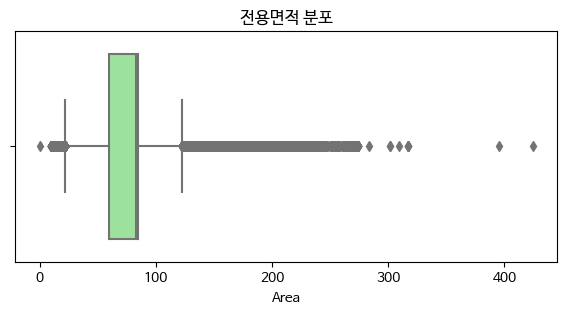

In [47]:
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = concat, x = 'exclusive_area', color='lightgreen')
plt.title('전용면적 분포')
plt.xlabel('Area')
plt.show()

In [48]:
def remove_outliers_iqr(dt, column_name):
    df = dt.query('is_test == 0')       # train data 내에 있는 이상치만 제거하도록 하겠습니다.
    df_test = dt.query('is_test == 1')
    
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df = df[(df[column_name] > lower_bound) & (df[column_name] < upper_bound)]
    return pd.concat([df, df_test])

concat = remove_outliers_iqr(concat, 'exclusive_area')

In [49]:
concat.shape

(657181, 75)

In [50]:
gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
concat['gangnam'] = concat['district'].apply(lambda x: 1 if x in gangnam else 0)

In [51]:
concat['new_apartment'] = concat['construction_year'].apply(lambda x: 1 if x >= 2012 else 0)

In [52]:
# 연차 변수 생성 (2023-계약년도+1)
concat['apartment_annual'] = 2023 - concat['construction_year'].astype(int) + 1

In [53]:
top_apartment_name = [
    '자이', '래미안', '파크', '더퍼스트', '센트럴', '포레', 
    '메트로', '에듀', '시티', '힐스테이트', '아이파크', '트리마제',
    '더샵', '더힐', '그랑자이', '아크로', '푸르지오'
]
concat['top_level_apartment'] =concat['apartment_name'].apply(lambda x: 1 if x in top_apartment_name else 0)

In [54]:
concat['top_level_apartment'].value_counts()

top_level_apartment
0    656418
1       763
Name: count, dtype: int64

In [55]:
concat.head(3)

,lot_number,main_number,sub_number,apartment_name,exclusive_area,contract_day,floor,construction_year,road_name,cancellation_reason_date,registration_application_date,transaction_type,broker_location,complex_classification,phone_number,fax_number,complex_description,household_type,management_type,corridor_type,heating_type,total_buildings,total_households,construction_company,developer,approval_date,gross_area,residential_area,maintenance_area,household_status_below_60sqm,household_status_60_to_85sqm,household_status_85_to_135sqm,household_status_above_135sqm,website,registration_date,modification_date,employment_insurance_number,security_management_type,electricity_contract_type,cleaning_management_type,building_area,parking_spaces,other_mandatory,complex_approval_date,usage_approval,maintenance_fee_upload,coordinate_x,coordinate_y,complex_application_date,target,rest_area_food,general_food,floor_log,cinema_distance,large_store_distance,government_bond_3yr,government_bond_5yr,government_bond_10yr,corporate_bond_3yr_aa_minus,cd_91_day,call_rate_1day_avg,base_rate,unique_key,within_500m_bus,nearest_distance,within_250m,within_500m,beyond_500m,is_test,city,district,town,contract_year,contract_month,contract_daytime,gangnam,new_apartment,apartment_annual,top_level_apartment
0,658-1,658.0,1.0,개포6차우성,79.97,8,3.0,1987.0,언주로 3,0.0,None,None,None,아파트,025776611,025776673,0.0,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,0.0,None,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,None,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000.0,1.0,1.0,2.079442,1.704474,1.500584,1.8,2.0,2.28,2.33,1.44,1.26,1.5,서울특별시 강남구 개포동 658-1,12.0,1197.220431,0.0,0.0,1.0,0,서울특별시,강남구,개포동,2017,12,2017-12-08 00:00:00,1,0,37,0
1,658-1,658.0,1.0,개포6차우성,79.97,22,4.0,1987.0,언주로 3,0.0,None,None,None,아파트,025776611,025776673,0.0,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,0.0,None,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,None,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,123500.0,1.0,1.0,2.197225,1.704474,1.500584,1.8,2.0,2.28,2.33,1.44,1.26,1.5,서울특별시 강남구 개포동 658-1,12.0,1197.220431,0.0,0.0,1.0,0,서울특별시,강남구,개포동,2017,12,2017-12-22 00:00:00,1,0,37,0
2,658-1,658.0,1.0,개포6차우성,54.98,28,5.0,1987.0,언주로 3,0.0,None,None,None,아파트,025776611,025776673,0.0,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,0.0,None,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,None,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,91500.0,1.0,1.0,2.302585,1.704474,1.500584,1.8,2.0,2.28,2.33,1.44,1.26,1.5,서울특별시 강남구 개포동 658-1,12.0,1197.220431,0.0,0.0,1.0,0,서울특별시,강남구,개포동,2017,12,2017-12-28 00:00:00,1,0,37,0


In [56]:
concat.isnull().sum()

lot_number                       0
main_number                      0
sub_number                       0
apartment_name                   0
exclusive_area                   0
contract_day                     0
floor                            0
construction_year                0
road_name                        0
cancellation_reason_date         0
registration_application_date    0
transaction_type                 0
broker_location                  0
complex_classification           0
phone_number                     0
fax_number                       0
complex_description              0
household_type                   0
management_type                  0
corridor_type                    0
heating_type                     0
total_buildings                  0
total_households                 0
construction_company             0
developer                        0
approval_date                    0
gross_area                       0
residential_area                 0
maintenance_area    

In [58]:
# 2020년 이후 데이터만 사용
concat = concat[concat['contract_year'] >= '2020']

In [59]:
concat.shape

(149870, 79)

In [60]:
for col in concat.columns:
    if concat[col].dtype == 'object':
        concat[col] = concat[col].astype(str)

In [61]:
# cat_col 라벨인코딩
le = LabelEncoder()
for col in cat_col:
    concat[col] = le.fit_transform(concat[col])    

In [62]:
concat.head(3)

,lot_number,main_number,sub_number,apartment_name,exclusive_area,contract_day,floor,construction_year,road_name,cancellation_reason_date,registration_application_date,transaction_type,broker_location,complex_classification,phone_number,fax_number,complex_description,household_type,management_type,corridor_type,heating_type,total_buildings,total_households,construction_company,developer,approval_date,gross_area,residential_area,maintenance_area,household_status_below_60sqm,household_status_60_to_85sqm,household_status_85_to_135sqm,household_status_above_135sqm,website,registration_date,modification_date,employment_insurance_number,security_management_type,electricity_contract_type,cleaning_management_type,building_area,parking_spaces,other_mandatory,complex_approval_date,usage_approval,maintenance_fee_upload,coordinate_x,coordinate_y,complex_application_date,target,rest_area_food,general_food,floor_log,cinema_distance,large_store_distance,government_bond_3yr,government_bond_5yr,government_bond_10yr,corporate_bond_3yr_aa_minus,cd_91_day,call_rate_1day_avg,base_rate,unique_key,within_500m_bus,nearest_distance,within_250m,within_500m,beyond_500m,is_test,city,district,town,contract_year,contract_month,contract_daytime,gangnam,new_apartment,apartment_annual,top_level_apartment
201009,3777,651.0,1.0,271,105.8064,21,8.0,2021.0,368,0.0,175,1,358,2,451,967,0.0,1,0,0,3,2.0,232.0,286,81,652,44951.0,24878.0,31174.0,0.0,0.0,232.0,0.0,103,110,208,518,1,2,1,2724.46,305.0,1,708,1,0,127.056394,37.484892,238,240000.0,1.0,1.0,2.564949,1.153743,0.685437,3.57,3.59,3.64,4.39,3.71,3.51,3.5,23,15.0,271.035667,0.0,1.0,0.0,0,0,0,8,3,5,1272,1,1,3,0
201010,1317,187.0,0.0,279,74.2500,22,10.0,1983.0,3451,0.0,55,1,338,2,359,892,317.0,1,0,2,3,6.0,940.0,132,154,13,93810.0,65960.0,65960.0,190.0,750.0,0.0,0.0,4,122,204,513,1,1,1,6524.00,652.0,1,270,1,0,127.068028,37.487802,30,210000.0,1.0,1.0,2.708050,2.132642,0.696899,3.57,3.59,3.64,4.39,3.71,3.51,3.5,20,24.0,266.288459,0.0,1.0,0.0,0,0,0,8,3,0,1095,1,0,41,0
201011,1317,187.0,0.0,279,61.1900,26,12.0,1983.0,3451,0.0,70,1,338,2,359,892,317.0,1,0,2,3,6.0,940.0,132,154,13,93810.0,65960.0,65960.0,190.0,750.0,0.0,0.0,4,122,204,513,1,1,1,6524.00,652.0,1,270,1,0,127.068028,37.487802,30,199000.0,1.0,1.0,2.833213,2.132642,0.696899,3.57,3.59,3.64,4.39,3.71,3.51,3.5,20,24.0,266.288459,0.0,1.0,0.0,0,0,0,8,3,1,1128,1,0,41,0


In [63]:
dt_train = concat.query('is_test==0')
dt_test = concat.query('is_test==1')

# is_test 칼럼은 drop
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(140598, 78) (9272, 78)


/tmp/ipykernel_487942/3123016756.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_train.drop(['is_test'], axis = 1, inplace=True)
/tmp/ipykernel_487942/3123016756.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_test.drop(['is_test'], axis = 1, inplace=True)


In [64]:
dt_test.head(1)

,lot_number,main_number,sub_number,apartment_name,exclusive_area,contract_day,floor,construction_year,road_name,cancellation_reason_date,registration_application_date,transaction_type,broker_location,complex_classification,phone_number,fax_number,complex_description,household_type,management_type,corridor_type,heating_type,total_buildings,total_households,construction_company,developer,approval_date,gross_area,residential_area,maintenance_area,household_status_below_60sqm,household_status_60_to_85sqm,household_status_85_to_135sqm,household_status_above_135sqm,website,registration_date,modification_date,employment_insurance_number,security_management_type,electricity_contract_type,cleaning_management_type,building_area,parking_spaces,other_mandatory,complex_approval_date,usage_approval,maintenance_fee_upload,coordinate_x,coordinate_y,complex_application_date,target,rest_area_food,general_food,floor_log,cinema_distance,large_store_distance,government_bond_3yr,government_bond_5yr,government_bond_10yr,corporate_bond_3yr_aa_minus,cd_91_day,call_rate_1day_avg,base_rate,unique_key,within_500m_bus,nearest_distance,within_250m,within_500m,beyond_500m,city,district,town,contract_year,contract_month,contract_daytime,gangnam,new_apartment,apartment_annual,top_level_apartment
0,3801,658.0,1.0,270,79.97,18,5.0,1987.0,4802,0.0,178,2,0,2,456,972,0.0,1,1,0,0,8.0,270.0,238,210,29,22637.0,20204.0,22637.0,20.0,250.0,0.0,0.0,4,115,206,518,3,1,3,4858.0,262.0,3,713,1,0,127.05721,37.476763,243,0.0,1.0,1.0,2.302585,1.704474,1.500584,3.57,3.59,3.64,4.39,3.71,3.51,3.5,29,12.0,1197.220431,0.0,0.0,1.0,0,0,8,3,6,1299,1,0,37,0


In [65]:
dt_test['target'] = 0

/tmp/ipykernel_487942/3345880597.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_test['target'] = 0


In [66]:
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# 학습 데이터와 검증 데이터를 8:2
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [69]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import StandardScaler

# 데이터 전처리
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 하이퍼파라미터 탐색 범위 정의
param_dist = {
    'iterations': [1000, 1500, 2000],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'depth': [6, 8, 10],
    'min_data_in_leaf': [1, 3, 5, 7],
    'l2_leaf_reg': [1, 3, 5, 7],
    'border_count': [128, 254],
    'bagging_temperature': [0.6, 0.8, 1.0],
    'random_strength': [0.5, 1, 1.5],
    'od_type': ['Iter'],
    'od_wait': [50, 100],
    'cat_features': [None],  # 범주형 변수가 있다면 해당 컬럼 인덱스 리스트로 지정
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bylevel': [0.8, 0.9, 1.0]
}

# CatBoost 모델 정의
def create_model(**params):
    return CatBoostRegressor(
        loss_function='RMSE',
        eval_metric='RMSE',
        random_seed=42,
        verbose=False,
        **params
    )

# KFold 정의
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV 설정
random_search = RandomizedSearchCV(
    estimator=create_model(),
    param_distributions=param_dist,
    n_iter=150,
    scoring='neg_root_mean_squared_error',
    cv=kf,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# RandomizedSearchCV 수행
random_search.fit(X_train_scaled, y_train)

# 최적의 하이퍼파라미터와 해당 점수 출력
print("Best parameters found: ", random_search.best_params_)
print("Best RMSE found: ", np.sqrt(-random_search.best_score_))

# 최적의 모델로 검증 세트에 대한 예측 수행
best_params = random_search.best_params_
best_model = CatBoostRegressor(**best_params, random_seed=42, use_best_model=True)

# eval_set을 사용하여 모델 훈련
best_model.fit(
    X_train_scaled, y_train,
    eval_set=(X_val_scaled, y_val),
    early_stopping_rounds=50,
    verbose=False
)

y_pred = best_model.predict(X_val_scaled)
print(f'Optimized CatBoost RMSE: {mean_squared_error(y_val, y_pred) ** 0.5}')

# 최종 모델 훈련 (전체 데이터셋 사용)
X_full = np.vstack((X_train_scaled, X_val_scaled))
y_full = np.concatenate((y_train, y_val))

final_model = CatBoostRegressor(**best_params, random_seed=42)
final_model.fit(X_full, y_full, verbose=False)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


KeyboardInterrupt: 

In [77]:
RMSE = np.sqrt(mean_squared_error(y_val, y_pred))
RMSE

8091.445298512972

In [79]:
%%time
X_test = dt_test.drop(['target'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = best_model.predict(X_test)

# RMSE 계산
from sklearn.metrics import mean_squared_error
import numpy as np

y_test = dt_test['target']
rmse = np.sqrt(mean_squared_error(y_test, real_test_pred))
print(f"Test dataset RMSE: {rmse}")

Test dataset RMSE: 119439.25431247355
CPU times: user 526 ms, sys: 0 ns, total: 526 ms
Wall time: 487 ms


In [80]:
%%time
X_test = dt_test.drop(['target'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = best_model.predict(X_test)

CPU times: user 35.6 ms, sys: 8.6 ms, total: 44.2 ms
Wall time: 12.4 ms


In [81]:
real_test_pred

array([161519.98584809, 313311.64515345, 269177.86067249, ...,
        74869.91985841,  64719.04394039,  62176.39810711])

In [82]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('/root/ML-Regression/Competition/predict_data/Cat&kfold2.csv', index=False)